In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
from numpy import linalg as lg
from scipy.spatial import distance_matrix
from sklearn.neighbors import kneighbors_graph
from collections import defaultdict
from sklearn.utils.graph_shortest_path import graph_shortest_path
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from numpy.linalg import svd 

In [2]:
class Graph:

  def __init__(self, adjmatrix):
    #graph can be defined by adjacency Matrix
    self.adjmatrix = adjmatrix
    #dictionary map each point to their neighbors.
    self.adjdict = {}
    for i, point in enumerate(self.adjmatrix):
      self.adjdict[i] = [j for j in range(len(point)) if point[j] != 0]


  def connected_components(self):
    # compute connected componeents of the graph
    visited = defaultdict(lambda: 0, {})
    cc = []
    for i in range(len(self.adjmatrix)):
      if visited[i] == 0:
        temp = []
        cc.append(self.DFS(temp, i, visited))
    return cc

  def DFS(self, temp, i, visited):
    visited[i] = 1
    temp.append(i)
    for j in self.adjdict[i]:
      if visited[j] == 0:
        # j is linked to 'point' and is not visited
        self.DFS(temp, j, visited)
    return temp
    

Processing data

In [3]:
data = pd.read_csv("zoo.data", header=None)
names = data.pop(0)
type = data.pop(17).to_numpy()
data = pd.get_dummies(data, columns = [13])
data_centred = pd.DataFrame(StandardScaler().fit_transform(data))

In [70]:
# counting the duplicates 
columns = [col for col in data.columns]
duplicated = data.pivot_table(index = columns, aggfunc ='size')
max(duplicated)

10

In [4]:
def plot(X, type):
  df = pd.DataFrame(data = X,  
                  columns = ['first ax', 'second ax']) 
  # plot different types with differents color.
  mapping= {1: "type_1", 2: "type_2", 3:"type_3", 4:"type_4", 5:"type_5", 6:"type_6", 7:"type_7", 8: "brown"}
  
  fig = px.scatter(df, x='first ax', y='second ax', color= [mapping[t] for t in type])
  fig.show()

**PCA with SVD**

In [5]:
# apply SVD on centred data
U, S, Vt = svd(np.transpose(data_centred), full_matrices=True)
# extract the two principales componentes
U_2 = U[:, [0, 1]]
#transform data
X_pca = np.dot(np.transpose(U_2), np.transpose(data_centred))
plot(np.transpose(X_pca), type)

In [6]:
# Reconstruction error of PCA:
X_reconstructed = np.dot(U_2, X_pca)
X = np.transpose(np.array(data_centred))
error_PCA = np.mean((X - X_reconstructed)**2)

0.5477519861535181

Implemented pca in python

In [7]:
# Use implemented pca in python
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_centred)
plot(principalComponents, type)

**My MDS**

Define features importance:

In [67]:
def compute_weight(X, y):
  # define the first model
  model = KNeighborsRegressor()
  # fit the model
  model.fit(X, y)
  # perform permutation importance
  results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
  # get the first importance
  importance_1 = results.importances_mean

  # define the second model
  model = RandomForestRegressor()
  # fit the model
  model.fit(X, y)
  # get the second importance
  importance_2 = model.feature_importances_

  #combine the two importances
  importance = []
  for i in range(len(importance_1)):
    importance.append((abs(importance_1[i]) + abs(importance_2[i]))/2)
  # summarize feature importance
  for i, v in enumerate(importance):
	  print('Feature: %0d, Score: %.5f' % (i,v))
  # plot feature importance
  pyplot.bar([x for x in range(len(importance))], importance)
  pyplot.show()
  return importance

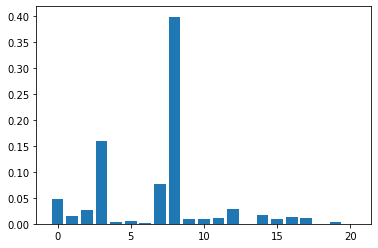

In [14]:
def MDS(df, k, predef_distance = False, weighted = False):
  if predef_distance:
    # if we give distance to MDS
    D = df
  else:
    #compute distances
    if weighted:
      #if we want to add importance of features to data
      weight_data = df.copy()
      importance = compute_weight(weight_data, type)
      for i, imp in enumerate(importance):
        weight_data[weight_data.columns[i]] = weight_data[weight_data.columns[i]].apply(lambda x: x * (imp + 1))
      D = distance_matrix(weight_data.values, weight_data.values)
    else:
      D = distance_matrix(df.values, df.values)
  n = len(D)
  #compute S by double centring
  ones = np.ones((n, n))
  S = - (1/2) * (D - (1/n) * np.dot(D, ones) - (1/n) * np.dot(ones, D) + (1/n**2) * np.dot(ones, np.dot(D, ones)))
  #EigenDecompostion
  eigenvalues, eigenvectors = lg.eig(S)
  eigenvalues, eigenvectors = np.abs(np.real(eigenvalues)), np.real(eigenvectors)
  lambdas = np.sqrt(np.diag(eigenvalues))
  X_mds = np.dot(np.eye(k, n), np.dot(lambdas, np.transpose(eigenvectors)))
  return np.transpose(X_mds)
X_mds = MDS(data, 2, False, True)
plot(X_mds, type)

**Isomap**

In [69]:
def isomap(df, p, k):
  X = df.to_numpy()
  graph = kneighbors_graph(X, p, mode='distance')
  A = kneighbors_graph(X, p, mode='connectivity').toarray()
  distances = graph_shortest_path(graph, directed = False, method = 'FW')
  X = MDS(distances, k, True, False)
  cc = Graph(A).connected_components()
  if(len(cc) != 1):
    print("The graph is disconnected. Therefore we will have", len(cc), "separated graphs")
  return X
X_iso = isomap(data, 16, 2)
plot(X_iso, type)

**Compute error**
As we demonstrate in the exercice number 5, PCA and classical MDS are equivalent. We will compare just PCA and Isomap. The problem is that PCA try to keep the euclidean distance between points constant. However Isomap try to keep the geodesic distance between points constant. So let first compare the two models by computing the geodisc error.

In [66]:
from sklearn.neighbors import NearestNeighbors

#compute errors (compare isomap to pca)
number_of_neighbors = 16

X_iso = isomap(data, number_of_neighbors, 2)
X_pca = pca.fit_transform(data_centred)
X_mds = MDS(data, 2)

nbrs = NearestNeighbors(n_neighbors=number_of_neighbors, algorithm='brute').fit(data)
distances, indices = nbrs.kneighbors(data)

nbrs = NearestNeighbors(n_neighbors=number_of_neighbors, algorithm='brute').fit(data_centred)
distances, indices_centred = nbrs.kneighbors(data_centred)

nbrs = NearestNeighbors(n_neighbors=number_of_neighbors, algorithm='brute').fit(X_iso)
distances, indices_iso = nbrs.kneighbors(X_iso)

nbrs = NearestNeighbors(n_neighbors=number_of_neighbors, algorithm='brute').fit(X_pca)
distances, indices_pca = nbrs.kneighbors(X_pca)

nbrs = NearestNeighbors(n_neighbors=number_of_neighbors, algorithm='brute').fit(X_mds)
distances, indices_mds = nbrs.kneighbors(X_mds)

error_iso = 0
error_pca = 0
error_mds = 0

for i in range(len(indices)):
  error_iso += len(set(indices[i]) - set(indices_iso[i]))
  error_pca += len(set(indices_centred[i]) - set(indices_pca[i]))
  error_mds += len(set(indices[i]) - set(indices_mds[i]))

print("Local structure error:")  
print("isomap error = ", error_iso/(len(indices)*number_of_neighbors))
print("mds error = ", error_mds/(len(indices)*number_of_neighbors))
print("pca error = ", error_pca/(len(indices)*number_of_neighbors))

error using geodisc distance:
isomap error =  0.30507425742574257
mds error =  0.3316831683168317
pca error =  0.32425742574257427
